# Analyse Velocity Changes for ROMY  & RLAS


## Load Libraries

In [1]:

import os
import pickle
import matplotlib.pyplot as plt
import numpy as np

from pandas import date_range

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [3]:
def __get_minimal_psd(psds):

    from numpy import nanmin, array, nonzero
    
    min_psd = zeros(psds.shape[1])
    
    for f in range(psds.shape[1]):
        a = psds[:,f]
        min_psd[f] = nanmin(a[nonzero(a)])
    
    return min_psd

In [4]:
def __get_median_psd(psds):

    from numpy import nanmedian, zeros, isnan

    med_psd = zeros(psds.shape[1])

    for f in range(psds.shape[1]):
        a = psds[:,f]
        med_psd[f] = nanmedian(a[~isnan(a)])

    return med_psd

In [5]:
def __get_mean_psd(psds):

    from numpy import mean, zeros, isnan

    mean_psd = zeros(psds.shape[1])

    for f in range(psds.shape[1]):
        a = psds[:,f]
        mean_psd[f] = mean(a[~isnan(a)])

    return mean_psd

In [6]:
def __get_minimum_psd(psds):
            
    for i, psd in enumerate(psds):
        if i == 0: 
            lowest_value = psd.sum()
            idx = 0

        value = psd.sum() 
        
        if value < lowest_value and value != 0:
            lowest_value = value
            idx = i   
    
    return psds[idx]

In [7]:
def __load_psds(file, config):

    ## get data to dataframe and transpose and reindex
    df = read_csv(file, index_col=False)
    df = df.transpose()
    df.reset_index(inplace=True)
    # df.dtypes
    # df.mean()

    ## set column names
    try:
        columns = pickle.load(open(f"{config['inpath']}{config['inname']}_columns.pick", 'rb'))
        df.columns = [column.replace("-","") for column in columns]
    except:
        columns = arange(0,df.shape[1]).astype(str)
        df.columns = columns
        print(" -> Failed to assign column names! Assigned numbers instead!")

    ## check for column dublicates
    if len(df.columns.unique()) != len(df.columns):
        print(f" -> removing {len(df.columns)-len(df.columns.unique())} column dublicate(s)!")
        df = df.loc[:,~df.columns.duplicated()]

    count=0
    dates_expected = date_range(config['date1'].date, config['date2'].date, periods=int((config['date2']-config['date1'])/86400)+1)
    for dex in dates_expected:
        dex=str(dex.isoformat()[:10]).replace("-","")
        if not dex in df.columns:
            count+=1
    print(f" -> missing {count} days")
        
    print(f" -> total of {df.shape[0]} psds")
        
#     ## convert to list
#     psds = []
#     for col in array(df.columns):
        
#         ## turn non-float series to float objects
#         df[col] = pd.to_numeric(df[col], errors = 'coerce')

#         ## add to psds list
#         psds.append(array(df[col]))
        
    return df

In [8]:
def __get_array_from_dataframe(df):
    
    from pandas import to_numeric
    
    ## convert to list
    psds = []
    for col in array(df.columns):
        
        ## turn non-float series to float objects
        df[col] = to_numeric(df[col], errors = 'coerce')

        ## add to psds list
        psds.append(array(df[col]))

    return array(psds)

In [9]:
def __get_percentiles(arr):

    from numpy import zeros, nanpercentile, shape

    percentiles_lower = zeros(shape(arr)[1])
    percentiles_upper = zeros(shape(arr)[1])

    for kk in range(shape(arr)[1]):
        out = nanpercentile(arr[:, kk],  [2.5 ,97.5])
        percentiles_upper[kk] = out[1]
        percentiles_lower[kk] = out[0]

    return percentiles_lower, percentiles_upper

## Configurations

In [23]:
config = {}

config['path_to_figures'] = f"{data_path}VelocityChanges/figures/"

config['rlnm_model_path'] = f"{root_path}LNM/data/MODELS/"

config['d1'], config['d2'] = "2023-09-23", "2023-10-22"

config['path_to_data'] = data_path+f"VelocityChanges/data/PSDS/"

## Load as Arrays

In [17]:
def __remove_noisy_psds(arr, threshold_mean=1e-16, ff=None, flim=None):

    from numpy import delete, shape, sort, array, ones, nan

    if flim is not None and ff is not None:
        for n, f in enumerate(ff):
            if f > flim:
                idx_max = n
                break

    idx_min = 5

    l1 = shape(arr)[0]

    idx_to_remove = []
    rejected = []
    for ii in range(shape(arr)[0]):

        ## appy upper threshold
        if flim is not None and ff is not None:
            if arr[ii, idx_min:idx_max].mean() > threshold_mean:
                if ii == 0:
                    print(f" -> filter threshold between {round(ff[idx_min],4)} and {round(ff[idx_max],2)}")
                rejected.append(arr[ii, :])
                arr[ii] = ones(len(arr[ii])) * nan
                # idx_to_remove.append(ii)
        else:
            if arr[ii, :].mean() > threshold_mean:
                rejected.append(arr[ii, :])
                idx_to_remove.append(ii)

        ## apply default lowe threshold
        if arr[ii, :].mean() < 1e-26:
            rejected.append(arr[ii, :])
            idx_to_remove.append(ii)

    # for jj in sort(array(idx_to_remove))[::-1]:
    #     arr = delete(arr, jj, axis=0)

    l2 = shape(arr)[0]

    print(f" -> removed {l1-l2} rows due to mean thresholds!")
    print(f" -> {l2} psds remain")

    return arr, rejected

In [11]:
def __get_fband_averages(_ff, _psds):

    from functions.get_fband_average import __get_fband_average
    from numpy import array

    psds = []
    for _n, _psd in enumerate(_psds):
        out0 = __get_fband_average(_ff, _psd, faction_of_octave=12 , average="median", plot=False)
        psds.append(out0['psd_means'])

    ff = out0['fcenter']
    psds = array(psds)

    return ff, psds

In [12]:
def __load_data_files(path, name, d1, d2):

    from numpy import array
    from pandas import read_pickle, date_range

    psds_all = []
    for _i, day in enumerate(date_range(config['d1'], config['d2'])):

        day = str(day).split(" ")[0].replace("-", "")

        year = day[:4]

        filename = f"{name}_3600_{day}_hourly.pkl"

        out = read_pickle(path+filename)
        ff = out['frequencies']

        psds_hourly = out['psd']
        for psd in psds_hourly:
            psds_all.append(psd)

    return ff, array(psds_all)

In [19]:
## Data1 --------------------------
name = f"ROMY/2023_ROMY_Z"

ff_romy, psd_romy = __load_data_files(config['path_to_data'], name, config['d1'], config['d2'])
tt_romy = np.arange(0, psd_romy.shape[0], 1)

ff_romy, psd_romy = __get_fband_averages(ff_romy, psd_romy)

psd_romy, rejected_romy = __remove_noisy_psds(psd_romy, threshold_mean=1e-19, ff=ff_romy, flim=0.05)


## Data2 --------------------------
name = f"RLAS/2023_RLAS"

ff_rlas, psd_rlas = __load_data_files(config['path_to_data'], name, config['d1'], config['d2'])
tt_rlas = np.arange(0, psd_rlas.shape[0], 1)

ff_rlas, psd_rlas = __get_fband_averages(ff_rlas, psd_rlas)

psd_rlas, rejected_rlas = __remove_noisy_psds(psd_rlas, threshold_mean=1e-20, ff=ff_rlas, flim=0.05)


 -> removed 0 rows due to mean thresholds!
 -> 720 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 720 psds remain


## Plot PSD Comparison

In [29]:
ff_ratio = ff_romy
tt_ratio = tt_romy

# ratio = np.divide(psd_romy, psd_rlas) * 100

ratio = []
for k in range(psd_romy.shape[0]):
    # ratio.append( ( psd_rlas[k,:] - psd_romy[k,:] ) / psd_romy[k,:] * 100 )
    ratio.append( psd_rlas[k,:] / psd_romy[k,:] * 100 )

ratio = np.array(ratio)

In [30]:
def __makeplot_image_overview(ff, psds, times, names):

    from numpy import isnan, median, mean, std, array, zeros, nanmax, nanmin, shape, nanpercentile
    from scipy.stats import median_abs_deviation as mad
    from matplotlib import colors


    ## convert frequencies to periods
    # pp=[]
    # for mm in range(len(ff)):
    #     ppp = zeros(len(ff[mm]))
    #     ppp = 1/ff[mm]
    #     pp.append(ppp)
    # pp[0] = 0

    ## define colormap
    cmap = plt.colormaps.get_cmap('viridis')
    cmap.set_bad(color='lightgrey')
#     cmap.set_under(color='black')
#     cmap.set_over(color='white')

    min0 = nanpercentile(psds[0].reshape(1, psds[0].size), 5)
    max0 = nanpercentile(psds[0].reshape(1, psds[0].size), 95)


    ##____________________________

#     NN = 3
    N = int(24*365)

    font = 14

    fig = plt.figure(constrained_layout=False, figsize=(15, 10))
    widths = [6, 1]
    heights = [1, 1, 1]

    spec = fig.add_gridspec(ncols=2, nrows=3, width_ratios=widths, height_ratios=heights)

    plt.subplots_adjust(hspace=0.15, wspace=0.02)

    ax1_1 = fig.add_subplot(spec[0, 0])
    ax1_2 = fig.add_subplot(spec[0, 1], sharey=ax1_1)
    ax2_1 = fig.add_subplot(spec[1, 0], sharex=ax1_1)
    ax2_2 = fig.add_subplot(spec[1, 1])
    ax3_1 = fig.add_subplot(spec[2, 0], sharex=ax1_1)
    ax3_2 = fig.add_subplot(spec[2, 1])

    im1 = ax1_1.pcolormesh( times[0]/24, ff[0], psds[0].T,
                            cmap=cmap,
                            norm=colors.LogNorm(2e-24, 2e-18),
                            rasterized=True,
                            )
    im2 = ax2_1.pcolormesh( times[1]/24, ff[1], psds[1].T,
                            cmap=cmap,
                            norm=colors.LogNorm(2e-24, 2e-18),
                            rasterized=True,
                            )
    im3 = ax3_1.pcolormesh( times[2]/24, ff[2], psds[2].T,
                            cmap=plt.colormaps.get_cmap('magma'),
                            # vmax=+3,
                            # vmin=-3,
                            rasterized=True,
                            norm=colors.LogNorm(),
                            )

    set_color = "seagreen"

    perc_lower, perc_upper = __get_percentiles((psds[0]))
    ax1_2.fill_betweenx(ff[0], perc_lower, perc_upper, color=set_color, zorder=3, alpha=0.4, label="")
    ax1_2.plot(__get_median_psd(psds[0]), ff[0], color=set_color, zorder=3, alpha=0.9, label="Median")

    perc_lower, perc_upper = __get_percentiles((psds[1]))
    ax2_2.fill_betweenx(ff[1], perc_lower, perc_upper, color=set_color, zorder=3, alpha=0.4, label="")
    ax2_2.plot(__get_median_psd(psds[1]), ff[1], color=set_color, zorder=3, alpha=0.9, label="Median")

    perc_lower, perc_upper = __get_percentiles((psds[2]))
    ax3_2.fill_betweenx(ff[2], perc_lower, perc_upper, color='grey', zorder=3, alpha=0.4, label="")
    ax3_2.plot(__get_median_psd(psds[2]), ff[2], color='black', zorder=3, alpha=0.9, label="Median")

    ax1_2.set_xlim(2e-24, 2e-18)
    ax2_2.set_xlim(2e-24, 2e-18)
    # ax3_2.set_xlim(0, 2)

    ax3_2.set_xscale("log")

    plt.setp(ax1_1.get_xticklabels(), visible=False)
    plt.setp(ax2_1.get_xticklabels(), visible=False)

#     plt.setp(ax1_2.get_xticklabels(), visible=False)
#     plt.setp(ax2_2.get_xticklabels(), visible=False)

    plt.setp(ax1_2.get_yticklabels(), visible=False)
    plt.setp(ax2_2.get_yticklabels(), visible=False)
    plt.setp(ax3_2.get_yticklabels(), visible=False)




    for ax in [ax1_1, ax1_2, ax2_1, ax2_2, ax3_1, ax3_2]:
        ax.tick_params(labelsize=font-2)
        ax.set_ylim(1e-2, 5e0)
        ax.set_yscale("log")

    ax1_2.set_xscale("logit")
    ax2_2.set_xscale("logit")

    ax3_1.set_xlabel("Time (days)", fontsize=font, labelpad=1)
    ax3_2.set_xlabel(r"", fontsize=font, labelpad=-1)

    # new_ticks = [int(round(t/24, 0)) for t in ax3_1.get_xticks()]
    # ax3_1.set_xticklabels(new_ticks)

#     ## panel labels
    ax1_1.text(-.08, .99, '(a)', ha='left', va='top', transform=ax1_1.transAxes, fontsize=font+2)
    ax2_1.text(-.08, .99, '(b)', ha='left', va='top', transform=ax2_1.transAxes, fontsize=font+2)
    ax3_1.text(-.08, .99, '(c)', ha='left', va='top', transform=ax3_1.transAxes, fontsize=font+2)

#     ## data labels
    ax1_1.text(.99, .97, f'{names[0]}', ha='right', va='top', transform=ax1_1.transAxes, fontsize=font)
    ax2_1.text(.99, .97, f'{names[1]}', ha='right', va='top', transform=ax2_1.transAxes, fontsize=font)
    ax3_1.text(.99, .97, f'{names[2]}', ha='right', va='top', transform=ax3_1.transAxes, fontsize=font)

    ax1_1.set_ylabel(r"Frequency (Hz)", fontsize=font)
    ax2_1.set_ylabel(r"Frequency (Hz)", fontsize=font)
    ax3_1.set_ylabel(r"Frequency (Hz)", fontsize=font)

#     ## set colorbar at bottom
    cbar = fig.colorbar(im1, orientation='vertical', ax=ax1_2, pad=0.05, extend="both")
    cbar.set_label(r"PSD (m$^2$/$s^4$/Hz)", fontsize=font-2, labelpad=1)

    cbar = fig.colorbar(im2, orientation='vertical', ax=ax2_2, pad=0.05, extend="both")
    cbar.set_label(r"PSD (rad$^2$/s$^2$/Hz)", fontsize=font-2, labelpad=1)

    cbar = fig.colorbar(im3, orientation='vertical', ax=ax3_2, pad=0.05, extend="max")
    cbar.set_label(r"Ratio (%)", fontsize=font-2, labelpad=1)

    plt.show();
    return fig

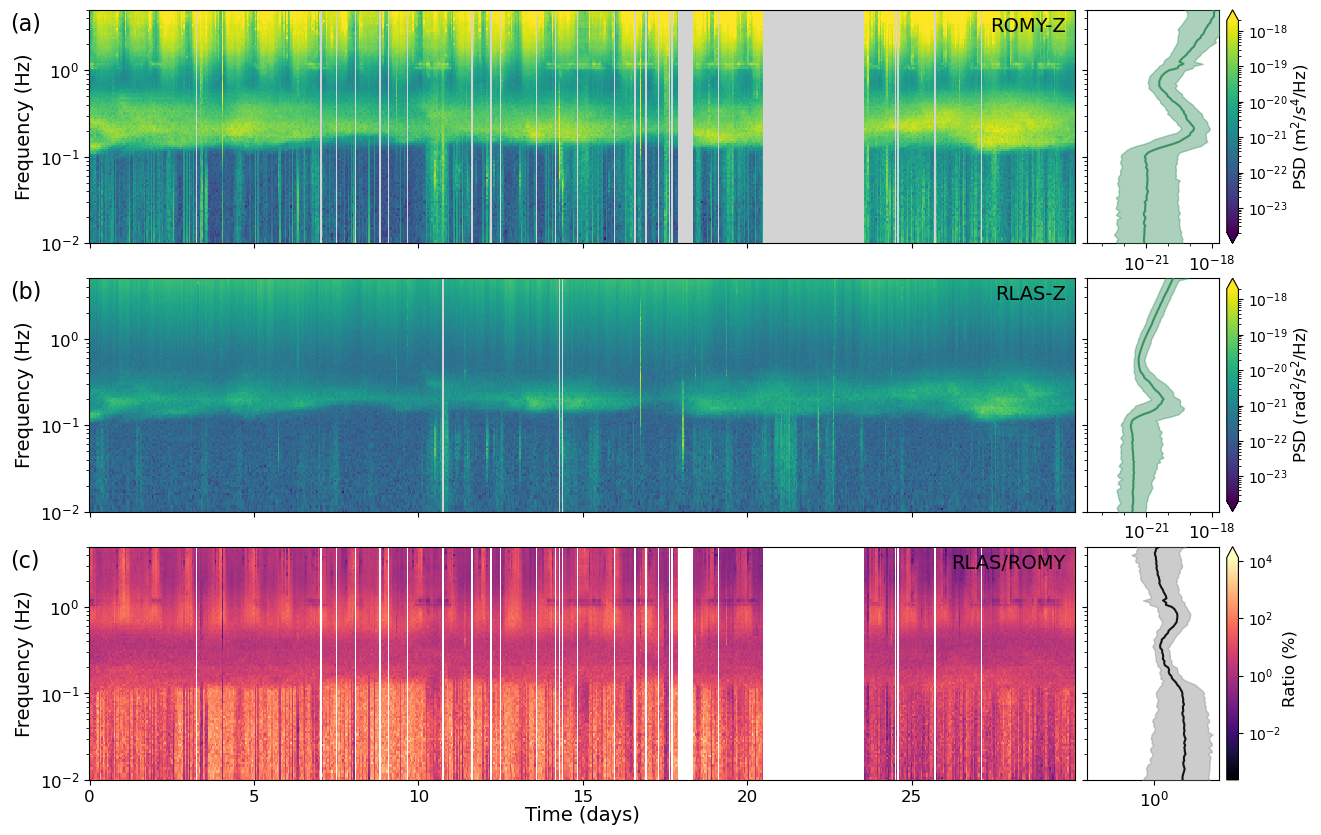

In [31]:
fig = __makeplot_image_overview(
                                [ff_romy, ff_rlas, ff_ratio],
                                [psd_romy, psd_rlas, ratio],
                                [tt_romy, tt_rlas, tt_ratio],
                                ["ROMY-Z", "RLAS-Z", "RLAS/ROMY"],
                                )

fig.savefig(config['path_to_figures']+f"TimeOverview_RLAS_ROMY_PSD_{config['d1']}_{config['d2']}.png", format="png", dpi=150, bbox_inches='tight')


## Plot RMS Comparison

In [32]:
def __get_rms(arr, ff):

    from numpy import zeros, shape, sqrt, nan, array
    from tqdm.notebook import tqdm

    rms = zeros(shape(arr))

    for ii, psd in enumerate(tqdm(arr)):

        rms_row = zeros(psd.size)
        for jj in range(psd.size):
            try:
                rms_row[jj] = sqrt(abs(psd[jj+1] - psd[jj]) * (ff[jj+1] - ff[jj]))
            except:
                rms_row[jj] = nan

        rms[ii] = array(rms_row)

    return rms

In [34]:
rms_romy = __get_rms(psd_romy, ff_romy)
rms_rlas = __get_rms(psd_rlas, ff_rlas)

rms_ratio = np.divide(rms_rlas, rms_romy) * 100


  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

In [41]:
def __makeplot_image_overview_RMS(ff, psds, times, names):

    from numpy import isnan, median, mean, std, array, zeros, nanmax, nanmin, shape, nanpercentile
    from scipy.stats import median_abs_deviation as mad
    from matplotlib import colors


    ## convert frequencies to periods
    # pp=[]
    # for mm in range(len(ff)):
    #     ppp = zeros(len(ff[mm]))
    #     ppp = 1/ff[mm]
    #     pp.append(ppp)
    # pp[0] = 0

    ## define colormap
    cmap = plt.colormaps.get_cmap('viridis')
    cmap.set_bad(color='lightgrey')
#     cmap.set_under(color='black')
#     cmap.set_over(color='white')

    min0 = nanpercentile(psds[0].reshape(1, psds[0].size), 5)
    max0 = nanpercentile(psds[0].reshape(1, psds[0].size), 95)


    ##____________________________

#     NN = 3
    N = int(24*365)

    font = 14

    fig = plt.figure(constrained_layout=False, figsize=(15, 10))
    widths = [6, 1]
    heights = [1, 1, 1]

    spec = fig.add_gridspec(ncols=2, nrows=3, width_ratios=widths, height_ratios=heights)

    plt.subplots_adjust(hspace=0.15, wspace=0.02)

    ax1_1 = fig.add_subplot(spec[0, 0])
    ax1_2 = fig.add_subplot(spec[0, 1], sharey=ax1_1)
    ax2_1 = fig.add_subplot(spec[1, 0], sharex=ax1_1)
    ax2_2 = fig.add_subplot(spec[1, 1])
    ax3_1 = fig.add_subplot(spec[2, 0], sharex=ax1_1)
    ax3_2 = fig.add_subplot(spec[2, 1])

    im1 = ax1_1.pcolormesh( times[0]/24, ff[0], psds[0].T,
                            cmap=cmap,
                            norm=colors.LogNorm(1e-14, 1e-9),
                            rasterized=True,
                            )
    im2 = ax2_1.pcolormesh( times[1]/24, ff[1], psds[1].T,
                            cmap=cmap,
                            norm=colors.LogNorm(1e-14, 1e-9),
                            rasterized=True,
                            )
    im3 = ax3_1.pcolormesh( times[2]/24, ff[2], psds[2].T,
                            cmap=plt.colormaps.get_cmap('magma'),
                            vmax=+100,
                            vmin=0,
                            rasterized=True,
                            # norm=colors.LogNorm(),
                            )

    set_color = "seagreen"

    perc_lower, perc_upper = __get_percentiles((psds[0]))
    ax1_2.fill_betweenx(ff[0], perc_lower, perc_upper, color=set_color, zorder=3, alpha=0.4, label="")
    ax1_2.plot(__get_median_psd(psds[0]), ff[0], color=set_color, zorder=3, alpha=0.9, label="Median")

    perc_lower, perc_upper = __get_percentiles((psds[1]))
    ax2_2.fill_betweenx(ff[1], perc_lower, perc_upper, color=set_color, zorder=3, alpha=0.4, label="")
    ax2_2.plot(__get_median_psd(psds[1]), ff[1], color=set_color, zorder=3, alpha=0.9, label="Median")

    perc_lower, perc_upper = __get_percentiles((psds[2]))
    ax3_2.fill_betweenx(ff[2], perc_lower, perc_upper, color='grey', zorder=3, alpha=0.4, label="")
    ax3_2.plot(__get_median_psd(psds[2]), ff[2], color='black', zorder=3, alpha=0.9, label="Median")

    ax1_2.set_xlim(1e-14, 1e-9)
    ax2_2.set_xlim(1e-14, 1e-9)
    ax3_2.set_xlim(0, 100)

    # ax3_2.set_xscale("log")

    plt.setp(ax1_1.get_xticklabels(), visible=False)
    plt.setp(ax2_1.get_xticklabels(), visible=False)

#     plt.setp(ax1_2.get_xticklabels(), visible=False)
#     plt.setp(ax2_2.get_xticklabels(), visible=False)

    plt.setp(ax1_2.get_yticklabels(), visible=False)
    plt.setp(ax2_2.get_yticklabels(), visible=False)
    plt.setp(ax3_2.get_yticklabels(), visible=False)




    for ax in [ax1_1, ax1_2, ax2_1, ax2_2, ax3_1, ax3_2]:
        ax.tick_params(labelsize=font-2)
        ax.set_ylim(1e-2, 5e0)
        ax.set_yscale("log")

    ax1_2.set_xscale("logit")
    ax2_2.set_xscale("logit")

    ax3_1.set_xlabel("Time (days)", fontsize=font, labelpad=1)
    ax3_2.set_xlabel(r"", fontsize=font, labelpad=-1)

    # new_ticks = [int(round(t/24, 0)) for t in ax3_1.get_xticks()]
    # ax3_1.set_xticklabels(new_ticks)

#     ## panel labels
    ax1_1.text(-.08, .99, '(a)', ha='left', va='top', transform=ax1_1.transAxes, fontsize=font+2)
    ax2_1.text(-.08, .99, '(b)', ha='left', va='top', transform=ax2_1.transAxes, fontsize=font+2)
    ax3_1.text(-.08, .99, '(c)', ha='left', va='top', transform=ax3_1.transAxes, fontsize=font+2)

#     ## data labels
    ax1_1.text(.99, .97, f'{names[0]}', ha='right', va='top', transform=ax1_1.transAxes, fontsize=font)
    ax2_1.text(.99, .97, f'{names[1]}', ha='right', va='top', transform=ax2_1.transAxes, fontsize=font)
    ax3_1.text(.99, .97, f'{names[2]}', ha='right', va='top', transform=ax3_1.transAxes, fontsize=font)

    ax1_1.set_ylabel(r"Frequency (Hz)", fontsize=font)
    ax2_1.set_ylabel(r"Frequency (Hz)", fontsize=font)
    ax3_1.set_ylabel(r"Frequency (Hz)", fontsize=font)

#     ## set colorbar at bottom
    cbar = fig.colorbar(im1, orientation='vertical', ax=ax1_2, pad=0.05, extend="both")
    cbar.set_label(r"RMS (m/$s^2$)", fontsize=font-2, labelpad=1)

    cbar = fig.colorbar(im2, orientation='vertical', ax=ax2_2, pad=0.05, extend="both")
    cbar.set_label(r"RMS (rad/s)", fontsize=font-2, labelpad=1)

    cbar = fig.colorbar(im3, orientation='vertical', ax=ax3_2, pad=0.05, extend="max")
    cbar.set_label(r"Ratio (%)", fontsize=font-2, labelpad=1)

    plt.show();
    return fig

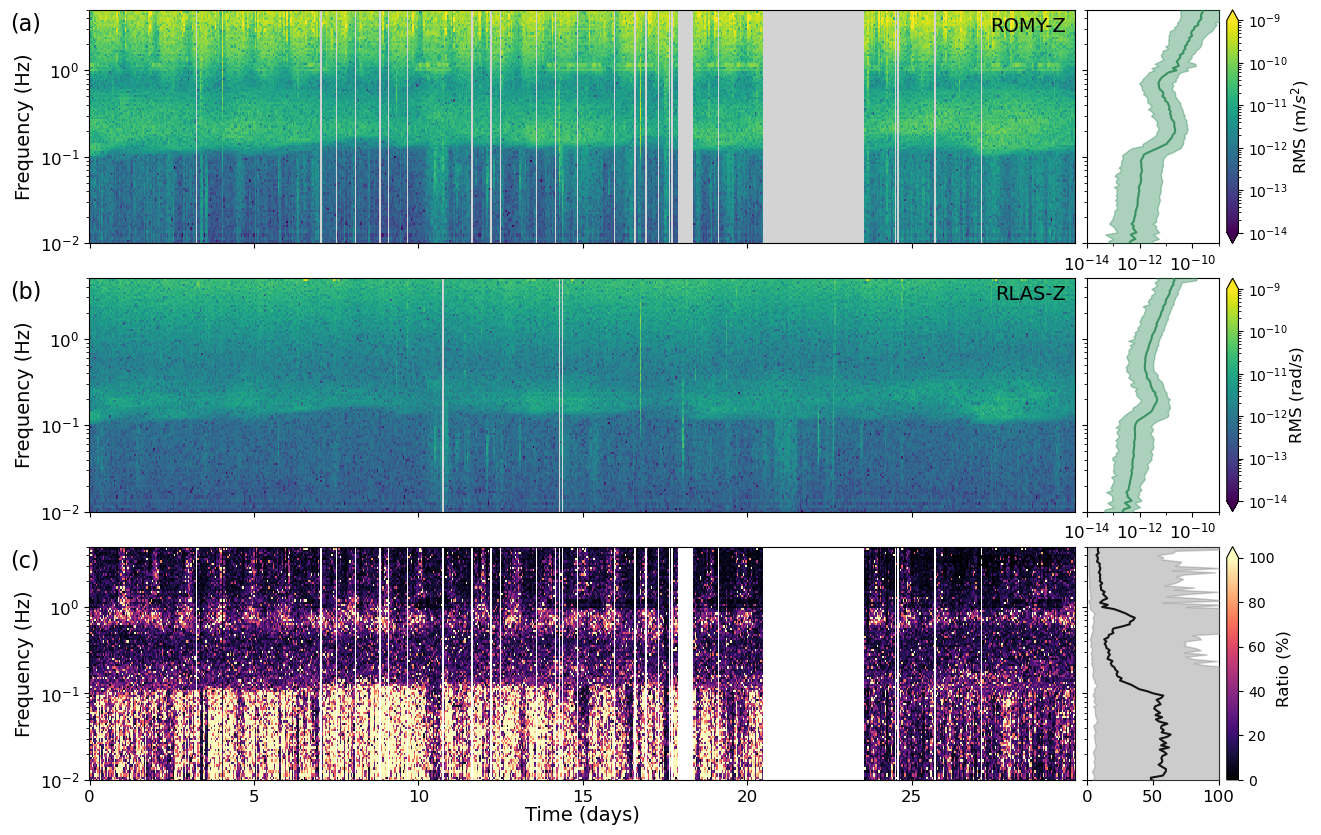

In [42]:
fig = __makeplot_image_overview_RMS(
                                    [ff_romy, ff_rlas, ff_ratio],
                                    [rms_romy, rms_rlas, rms_ratio],
                                    [tt_romy, tt_rlas, tt_ratio],
                                    ["ROMY-Z", "RLAS-Z", "RLAS/ROMY"],
                                    )

fig.savefig(config['path_to_figures']+f"TimeOverview_RLAS_ROMY_RMS_{config['d1']}_{config['d2']}.png", format="png", dpi=150, bbox_inches='tight')
